# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../rnn/sliding_windows_google.png)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [4]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 750   

t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,0.116942
1,-0.398601
2,-0.304344
3,0.556946
4,0.306549


In [5]:
window_length = 200
window_step = 10

def moving_window(df, window_length, window_step):
    window_list = []
    for i in range(0, len(df)+1-window_length, window_step):
        window_list.append(df.values[i:i+window_length])
    return np.array(window_list)


In [6]:
data = moving_window(df, window_length, window_step)

In [7]:
data.shape

(281, 200, 1)

In [8]:
Tp = round(window_length*0.8)
train = data[:, :Tp]
test = data[:, Tp:window_length]

In [9]:
train.shape

(281, 160, 1)

In [10]:
test.shape

(281, 40, 1)

In [11]:
len(test)

281

In [12]:
test[0][-1,]

array([-0.74292315])

In [13]:
step = 4

train_ = []
test_ = []
# add step elements into train and test
for i in range(len(test)):
    testing = np.append(test[i],np.repeat(test[i][-1,],step))
    training = np.append(train[i],np.repeat(train[i][-1,],step))
    test_.append(testing)
    train_.append(training)
test_ = np.array(test_)
train_ = np.array(train_)

In [14]:
test_.shape

(281, 44)

In [15]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [16]:
def convertToWindowMatrix(data, step):
    X, Y = [], []
    for i in range(len(data)):
        x, y = convertToMatrix(data[i], step)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [17]:
TrainX, TrainY = convertToWindowMatrix(train_, step)
X_test, Y_test = convertToWindowMatrix(test_, step)

In [18]:
print(TrainX.shape)
print(TrainY.shape)
print(X_test.shape)
print(Y_test.shape)

(281, 160, 4)
(281, 160)
(281, 40, 4)
(281, 40)


In [19]:
trainX = np.reshape(TrainX, (TrainX.shape[0], TrainX.shape[1], 1, TrainX.shape[2]))
testX = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, X_test.shape[2]))

In [20]:
print(trainX.shape)
print(TrainY.shape)
print(testX.shape)
print(Y_test.shape)

(281, 160, 1, 4)
(281, 160)
(281, 40, 1, 4)
(281, 40)


In [21]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [22]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [23]:
model = build_simple_rnn()
batch_size=16
num_epochs = 100

for i in range(len(trainX)):
    print('window', i)
    model.fit(trainX[i],TrainY[i], epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()],verbose=0)

C:\Users\barke\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
window 0
Epoch number 50 done
Epoch number 100 done
window 1
Epoch number 50 done
Epoch number 100 done
window 2
Epoch number 50 done
Epoch number 100 done
window 3
Epoch number 50 done
Epoch number 100 done
window 4
Epoch number 50 done
Epoch number 100 done
window 5
Epoch number 50 done
Epoch number 100 done
window 6
Epoch number 50 done
Epoch number 100 done
window 7
Epoch number 50 done
Epoch number 100 done
window 8
Epoch number 50 done
Epoch number 100 done
window 9
Epoch number 50 done
Epoch number 100 done
window 10
Epoch number 50 done
Epoch number 100 done
window 11
Epoch number 50 done
Epoch number 100 done
window 12
Epoch number 50 done
Epoch number 100 done
window 13
Epoch number 50 done
Epoch number 100 d

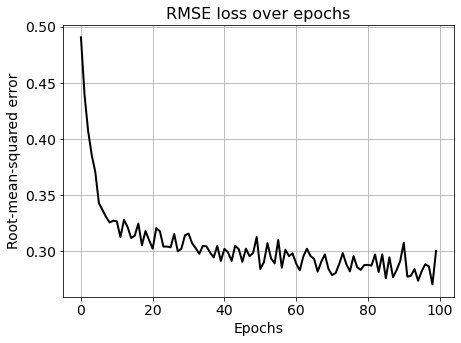

In [24]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [25]:
for i in range(len(trainX)):
    print('window', i)
    model.fit(trainX[i],TrainY[i], epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()],verbose=0)

window 0
Epoch number 50 done
Epoch number 100 done
window 1
Epoch number 50 done
Epoch number 100 done
window 2
Epoch number 50 done
Epoch number 100 done
window 3
Epoch number 50 done
Epoch number 100 done
window 4
Epoch number 50 done
Epoch number 100 done
window 5
Epoch number 50 done
Epoch number 100 done
window 6
Epoch number 50 done
Epoch number 100 done
window 7
Epoch number 50 done
Epoch number 100 done
window 8
Epoch number 50 done
Epoch number 100 done
window 9
Epoch number 50 done
Epoch number 100 done
window 10
Epoch number 50 done
Epoch number 100 done
window 11
Epoch number 50 done
Epoch number 100 done
window 12
Epoch number 50 done
Epoch number 100 done
window 13
Epoch number 50 done
Epoch number 100 done
window 14
Epoch number 50 done
Epoch number 100 done
window 15
Epoch number 50 done
Epoch number 100 done
window 16
Epoch number 50 done
Epoch number 100 done
window 17
Epoch number 50 done
Epoch number 100 done
window 18
Epoch number 50 done
Epoch number 100 done
win

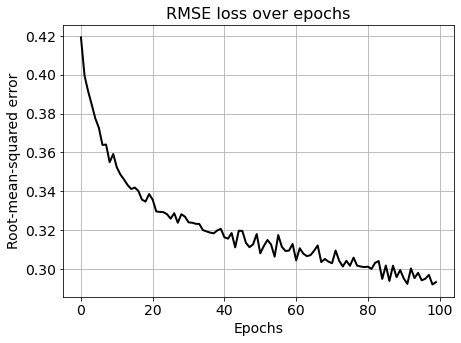

In [26]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()